In [200]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import MIDAS
from weights import Beta
from base import BaseModel
from helper_functions import create_matrix
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm

## Mixed Data Sampling Simulation

The simulation was inspired from [Conrad and Kleen (2019)] research paper. <br>
Suppose we have $X_t$ is an AR(1) process, that:
$$X_{i,t} = \phi X_{i-1, t} + \epsilon_t$$
where t = 1, ...,T, i = 1, ...,$I_t$, $I_t$ equals to 22. $\phi = 0.9$ and $\epsilon_t \sim \mathcal{N}(0, 1)$ standard normal variable, than the MIDAS equation will be:
$$y_t = m + \theta \sum_{k=0}^K \xi_k (1, w) X_{i-k, t}$$
with the parameters m = 0.1, $\theta = 0.3$ and w = 4.0. To see how accurate our code about to estimate the theoratical parameters, we run Monte Carlo simulation with three sample size (T), namely 100, 200, 400. It comes out, that with very small sample size it can estimate parameters accurately.

In [162]:
class MIDAS_sim(BaseModel):
    def __init__(self, lag = 22, plot = True, *args):
        self.lag = lag
        self.plot = plot
        self.args = args
        
    def initialize_params(self, X):
        self.init_params = np.linspace(1, 1, 3)
        return self.init_params
    
    def model_filter(self, params, X, y):
        model = np.zeros(len(y))
        
        for i in range(len(y)):
            model[i] = params[0] + params[1] * Beta().x_weighted(X[i * self.lag : (i + 1) * self.lag].reshape((1, self.lag)), [1.0, params[2]])
        
        return model
    
    def loglikelihood(self, params, X, y):
        return np.sum((y - self.model_filter(params, X, y)) ** 2)
    
    def simulate(self, params = [0.1, 0.3, 4.0], num = 500, K = 22):
        X = np.zeros(num * K)
        y = np.zeros(num)
        
        for i in range(num * K):
            if i == 0:
                X[i] = np.random.normal()
            else:
                X[i] = 0.9 * X[i - 1] + np.random.normal()
                
        for i in range(num):
            y[i] = params[0] + params[1] * Beta().x_weighted(X[i * K : (i + 1) * K].reshape((1, K)), [1.0, params[2]])
        
        return X, y

In [175]:
def create_sim(sim_num = 500, sim_length = 500):
    lls, m, theta, w, runtime = np.zeros(sim_num), np.zeros(sim_num), np.zeros(sim_num), np.zeros(sim_num), np.zeros(sim_num)
    params = [0.1, 0.3, 4.0]
    
    model = MIDAS_sim(plot = False)
    
    for i in range(sim_num):
        np.random.seed(i)
        X, y = model.simulate(num = sim_length)
        start = time.time()
        model.fit(['', 'pos', 'pos'], X, y)
        runtime[i] = time.time() - start
        print("{}st iteration's runTime: {} sec.\n".format(i+1, round(runtime[i], 4)))
        lls[i], m[i], theta[i], w[i] = model.opt.fun, model.optimized_params[0], model.optimized_params[1], model.optimized_params[2]
        
    return lls, m, theta, w, runtime

In [176]:
sim500 = pd.DataFrame(create_sim(sim_length = 100))

1st iteration's runTime: 1.4968 sec.

2st iteration's runTime: 1.5151 sec.

3st iteration's runTime: 1.5199 sec.

4st iteration's runTime: 1.7461 sec.

5st iteration's runTime: 2.0134 sec.

6st iteration's runTime: 1.8903 sec.

7st iteration's runTime: 1.8185 sec.

8st iteration's runTime: 1.7842 sec.

9st iteration's runTime: 1.7054 sec.

10st iteration's runTime: 1.5957 sec.

11st iteration's runTime: 1.4531 sec.

12st iteration's runTime: 1.4621 sec.

13st iteration's runTime: 1.5618 sec.

14st iteration's runTime: 1.5649 sec.

15st iteration's runTime: 1.4551 sec.

16st iteration's runTime: 1.5747 sec.

17st iteration's runTime: 1.4531 sec.

18st iteration's runTime: 1.4541 sec.

19st iteration's runTime: 1.3464 sec.

20st iteration's runTime: 1.4501 sec.

21st iteration's runTime: 1.5638 sec.

22st iteration's runTime: 1.5708 sec.

23st iteration's runTime: 1.4551 sec.

24st iteration's runTime: 1.6865 sec.

25st iteration's runTime: 1.5558 sec.

26st iteration's runTime: 1.5798 s

209st iteration's runTime: 1.5708 sec.

210st iteration's runTime: 1.4621 sec.

211st iteration's runTime: 1.4581 sec.

212st iteration's runTime: 1.459 sec.

213st iteration's runTime: 1.6825 sec.

214st iteration's runTime: 1.5548 sec.

215st iteration's runTime: 1.5489 sec.

216st iteration's runTime: 1.5947 sec.

217st iteration's runTime: 1.5927 sec.

218st iteration's runTime: 1.6645 sec.

219st iteration's runTime: 1.5618 sec.

220st iteration's runTime: 1.4482 sec.

221st iteration's runTime: 1.5518 sec.

222st iteration's runTime: 1.4481 sec.

223st iteration's runTime: 1.3284 sec.

224st iteration's runTime: 1.5558 sec.

225st iteration's runTime: 1.4458 sec.

226st iteration's runTime: 1.5589 sec.

227st iteration's runTime: 1.4511 sec.

228st iteration's runTime: 1.4541 sec.

229st iteration's runTime: 1.6326 sec.

230st iteration's runTime: 1.4671 sec.

231st iteration's runTime: 1.4571 sec.

232st iteration's runTime: 1.4528 sec.

233st iteration's runTime: 1.3468 sec.

2

415st iteration's runTime: 1.6196 sec.

416st iteration's runTime: 1.6396 sec.

417st iteration's runTime: 1.504 sec.

418st iteration's runTime: 1.6097 sec.

419st iteration's runTime: 1.503 sec.

420st iteration's runTime: 1.513 sec.

421st iteration's runTime: 1.6107 sec.

422st iteration's runTime: 1.496 sec.

423st iteration's runTime: 1.6177 sec.

424st iteration's runTime: 1.511 sec.

425st iteration's runTime: 1.6137 sec.

426st iteration's runTime: 1.6256 sec.

427st iteration's runTime: 1.498 sec.

428st iteration's runTime: 1.6027 sec.

429st iteration's runTime: 1.494 sec.

430st iteration's runTime: 1.6266 sec.

431st iteration's runTime: 1.9131 sec.

432st iteration's runTime: 1.5215 sec.

433st iteration's runTime: 1.6459 sec.

434st iteration's runTime: 1.5539 sec.

435st iteration's runTime: 1.7017 sec.

436st iteration's runTime: 1.6806 sec.

437st iteration's runTime: 1.6254 sec.

438st iteration's runTime: 1.6814 sec.

439st iteration's runTime: 1.5578 sec.

440st i

In [177]:
sim200 = pd.DataFrame(create_sim(sim_length = 200))

1st iteration's runTime: 3.2502 sec.

2st iteration's runTime: 3.0007 sec.

3st iteration's runTime: 3.3598 sec.

4st iteration's runTime: 3.5303 sec.

5st iteration's runTime: 3.2847 sec.

6st iteration's runTime: 2.8855 sec.

7st iteration's runTime: 3.2949 sec.

8st iteration's runTime: 3.0271 sec.

9st iteration's runTime: 3.0379 sec.

10st iteration's runTime: 3.015 sec.

11st iteration's runTime: 3.2839 sec.

12st iteration's runTime: 3.0533 sec.

13st iteration's runTime: 3.0014 sec.

14st iteration's runTime: 3.2227 sec.

15st iteration's runTime: 2.7762 sec.

16st iteration's runTime: 3.2034 sec.

17st iteration's runTime: 3.2368 sec.

18st iteration's runTime: 2.9963 sec.

19st iteration's runTime: 3.2309 sec.

20st iteration's runTime: 3.2207 sec.

21st iteration's runTime: 3.0026 sec.

22st iteration's runTime: 3.2453 sec.

23st iteration's runTime: 2.9968 sec.

24st iteration's runTime: 3.2447 sec.

25st iteration's runTime: 2.7705 sec.

26st iteration's runTime: 2.7544 se

210st iteration's runTime: 3.1127 sec.

211st iteration's runTime: 3.0897 sec.

212st iteration's runTime: 3.0987 sec.

213st iteration's runTime: 3.37 sec.

214st iteration's runTime: 3.3421 sec.

215st iteration's runTime: 3.3441 sec.

216st iteration's runTime: 3.4348 sec.

217st iteration's runTime: 3.3301 sec.

218st iteration's runTime: 3.3301 sec.

219st iteration's runTime: 3.4119 sec.

220st iteration's runTime: 3.2583 sec.

221st iteration's runTime: 3.3351 sec.

222st iteration's runTime: 3.1476 sec.

223st iteration's runTime: 2.9282 sec.

224st iteration's runTime: 3.1426 sec.

225st iteration's runTime: 3.4119 sec.

226st iteration's runTime: 3.369 sec.

227st iteration's runTime: 2.8703 sec.

228st iteration's runTime: 3.1775 sec.

229st iteration's runTime: 2.8563 sec.

230st iteration's runTime: 3.1446 sec.

231st iteration's runTime: 3.1147 sec.

232st iteration's runTime: 3.1047 sec.

233st iteration's runTime: 3.3321 sec.

234st iteration's runTime: 3.1636 sec.

235

416st iteration's runTime: 3.3211 sec.

417st iteration's runTime: 3.0159 sec.

418st iteration's runTime: 3.4947 sec.

419st iteration's runTime: 3.4806 sec.

420st iteration's runTime: 3.6902 sec.

421st iteration's runTime: 3.2803 sec.

422st iteration's runTime: 3.3321 sec.

423st iteration's runTime: 3.2503 sec.

424st iteration's runTime: 3.2334 sec.

425st iteration's runTime: 3.4937 sec.

426st iteration's runTime: 3.2261 sec.

427st iteration's runTime: 3.2403 sec.

428st iteration's runTime: 3.021 sec.

429st iteration's runTime: 3.2862 sec.

430st iteration's runTime: 3.2523 sec.

431st iteration's runTime: 3.1945 sec.

432st iteration's runTime: 3.1985 sec.

433st iteration's runTime: 3.4857 sec.

434st iteration's runTime: 3.2643 sec.

435st iteration's runTime: 3.2055 sec.

436st iteration's runTime: 3.2563 sec.

437st iteration's runTime: 3.5585 sec.

438st iteration's runTime: 3.5934 sec.

439st iteration's runTime: 3.5375 sec.

440st iteration's runTime: 3.5506 sec.

4

In [185]:
sim400 = pd.DataFrame(create_sim(sim_length = 400))

1st iteration's runTime: 5.86 sec.

2st iteration's runTime: 6.4272 sec.

3st iteration's runTime: 5.8903 sec.

4st iteration's runTime: 6.3532 sec.

5st iteration's runTime: 6.4308 sec.

6st iteration's runTime: 6.255 sec.

7st iteration's runTime: 6.2452 sec.

8st iteration's runTime: 5.828 sec.

9st iteration's runTime: 6.3008 sec.

10st iteration's runTime: 5.8076 sec.

11st iteration's runTime: 5.8236 sec.

12st iteration's runTime: 5.8066 sec.

13st iteration's runTime: 5.9073 sec.

14st iteration's runTime: 5.8104 sec.

15st iteration's runTime: 5.4553 sec.

16st iteration's runTime: 5.8057 sec.

17st iteration's runTime: 5.7638 sec.

18st iteration's runTime: 5.7874 sec.

19st iteration's runTime: 5.7521 sec.

20st iteration's runTime: 6.2538 sec.

21st iteration's runTime: 5.7917 sec.

22st iteration's runTime: 6.2063 sec.

23st iteration's runTime: 5.2909 sec.

24st iteration's runTime: 5.801 sec.

25st iteration's runTime: 5.3353 sec.

26st iteration's runTime: 5.7462 sec.



209st iteration's runTime: 6.4267 sec.

210st iteration's runTime: 5.9688 sec.

211st iteration's runTime: 6.0302 sec.

212st iteration's runTime: 5.9728 sec.

213st iteration's runTime: 6.4356 sec.

214st iteration's runTime: 5.879 sec.

215st iteration's runTime: 5.8497 sec.

216st iteration's runTime: 6.0867 sec.

217st iteration's runTime: 5.5219 sec.

218st iteration's runTime: 5.741 sec.

219st iteration's runTime: 6.7263 sec.

220st iteration's runTime: 6.4096 sec.

221st iteration's runTime: 6.116 sec.

222st iteration's runTime: 5.9188 sec.

223st iteration's runTime: 5.8513 sec.

224st iteration's runTime: 6.499 sec.

225st iteration's runTime: 6.343 sec.

226st iteration's runTime: 6.3669 sec.

227st iteration's runTime: 5.4815 sec.

228st iteration's runTime: 6.3772 sec.

229st iteration's runTime: 5.5555 sec.

230st iteration's runTime: 6.4867 sec.

231st iteration's runTime: 6.4711 sec.

232st iteration's runTime: 5.9332 sec.

233st iteration's runTime: 6.2885 sec.

234st

415st iteration's runTime: 5.7653 sec.

416st iteration's runTime: 5.3334 sec.

417st iteration's runTime: 6.3853 sec.

418st iteration's runTime: 5.9031 sec.

419st iteration's runTime: 5.7809 sec.

420st iteration's runTime: 6.3721 sec.

421st iteration's runTime: 5.7997 sec.

422st iteration's runTime: 5.9556 sec.

423st iteration's runTime: 6.4064 sec.

424st iteration's runTime: 5.3703 sec.

425st iteration's runTime: 6.223 sec.

426st iteration's runTime: 5.432 sec.

427st iteration's runTime: 5.9414 sec.

428st iteration's runTime: 8.2172 sec.

429st iteration's runTime: 8.743 sec.

430st iteration's runTime: 6.0819 sec.

431st iteration's runTime: 6.6133 sec.

432st iteration's runTime: 6.4644 sec.

433st iteration's runTime: 6.0038 sec.

434st iteration's runTime: 6.4453 sec.

435st iteration's runTime: 6.4586 sec.

436st iteration's runTime: 6.0006 sec.

437st iteration's runTime: 6.5529 sec.

438st iteration's runTime: 6.4561 sec.

439st iteration's runTime: 5.9716 sec.

440

In [179]:
sim200 = sim200.T
sim500 = sim500.T

In [186]:
sim400 = sim400.T

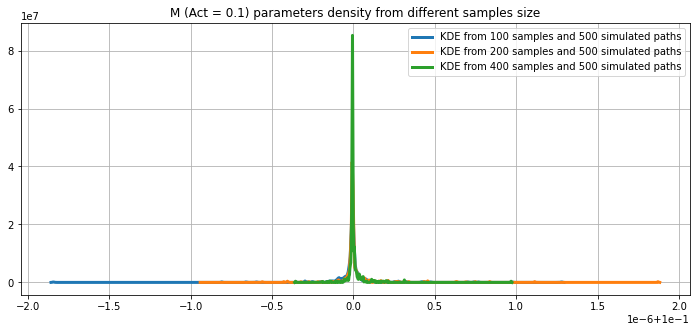

In [187]:
kde1000 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 1].values)
kde1000.fit()
kde4000 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 1].values)
kde4000.fit()
kde8000 = sm.nonparametric.KDEUnivariate(sim400.iloc[:, 1].values)
kde8000.fit()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(kde1000.support, kde1000.density, lw = 3, label = 'KDE from 100 samples and 500 simulated paths', zorder = 10)
ax.plot(kde4000.support, kde4000.density, lw = 3, label = 'KDE from 200 samples and 500 simulated paths', zorder = 10)
ax.plot(kde8000.support, kde8000.density, lw = 3, label = 'KDE from 400 samples and 500 simulated paths', zorder = 10)

plt.title('M (Act = 0.1) parameters density from different samples size')
#ax.set_xlim((0.0, 0.1))
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

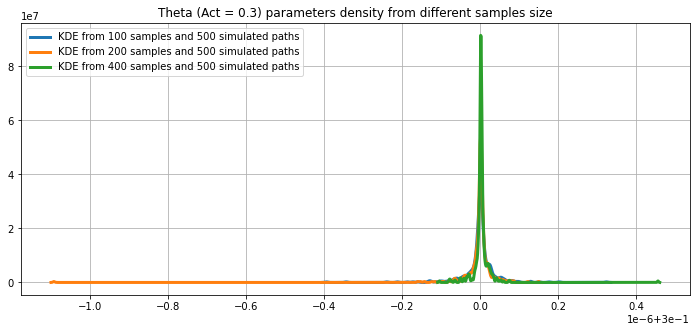

In [188]:
kde1000 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 2].values)
kde1000.fit()
kde4000 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 2].values)
kde4000.fit()
kde8000 = sm.nonparametric.KDEUnivariate(sim400.iloc[:, 2].values)
kde8000.fit()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(kde1000.support, kde1000.density, lw = 3, label = 'KDE from 100 samples and 500 simulated paths', zorder = 10)
ax.plot(kde4000.support, kde4000.density, lw = 3, label = 'KDE from 200 samples and 500 simulated paths', zorder = 10)
ax.plot(kde8000.support, kde8000.density, lw = 3, label = 'KDE from 400 samples and 500 simulated paths', zorder = 10)

plt.title('Theta (Act = 0.3) parameters density from different samples size')
#ax.set_xlim((0.0, 0.1))
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

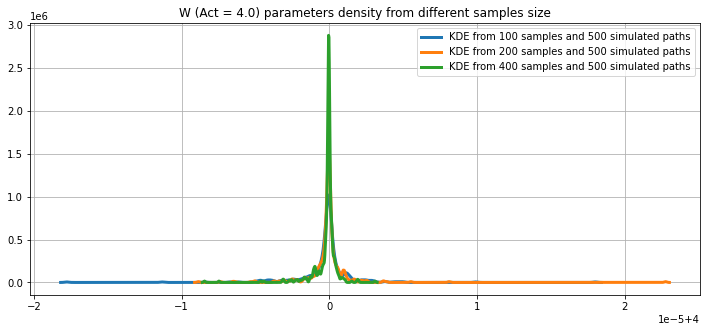

In [189]:
kde1000 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 3].values)
kde1000.fit()
kde4000 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 3].values)
kde4000.fit()
kde8000 = sm.nonparametric.KDEUnivariate(sim400.iloc[:, 3].values)
kde8000.fit()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(kde1000.support, kde1000.density, lw = 3, label = 'KDE from 100 samples and 500 simulated paths', zorder = 10)
ax.plot(kde4000.support, kde4000.density, lw = 3, label = 'KDE from 200 samples and 500 simulated paths', zorder = 10)
ax.plot(kde8000.support, kde8000.density, lw = 3, label = 'KDE from 400 samples and 500 simulated paths', zorder = 10)

plt.title('W (Act = 4.0) parameters density from different samples size')
#ax.set_xlim((0.0, 0.1))
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

In [190]:
sim500.describe()

,0,1,2,3,4
count,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,4.396472e-12,1.000000e-01,3.000000e-01,4.000000,1.562664
std,2.279552e-11,1.566619e-07,4.779561e-08,0.000002,0.163047
min,2.351981e-16,9.999816e-02,2.999996e-01,3.999982,1.282569
25%,1.861274e-14,9.999998e-02,3.000000e-01,4.000000,1.463832
50%,1.481415e-13,9.999999e-02,3.000000e-01,4.000000,1.553855
75%,1.096874e-12,1.000000e-01,3.000000e-01,4.000000,1.614187
max,3.401766e-10,1.000013e-01,3.000003e-01,4.000018,2.687158


In [191]:
sim200.describe()

,0,1,2,3,4
count,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,7.617762e-12,1.000000e-01,3.000000e-01,4.000000,3.286280
std,5.587798e-11,1.487739e-07,5.597541e-08,0.000002,0.340616
min,1.365257e-15,9.999907e-02,2.999989e-01,3.999991,2.754428
25%,1.884701e-14,9.999999e-02,3.000000e-01,4.000000,3.111676
50%,1.083243e-13,9.999999e-02,3.000000e-01,4.000000,3.235347
75%,9.781283e-13,1.000000e-01,3.000000e-01,4.000000,3.362300
max,9.072058e-10,1.000019e-01,3.000002e-01,4.000023,7.202728


In [199]:
sim400.describe()

,0,1,2,3,4
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.000000
mean,3.361413e-12,1.000000e-01,3.000000e-01,4.000000e+00,6.123297
std,3.053498e-11,6.243153e-08,2.644636e-08,8.319192e-07,0.342964
min,2.635171e-15,9.999964e-02,2.999999e-01,3.999992e+00,5.290931
25%,2.397521e-14,9.999999e-02,3.000000e-01,4.000000e+00,5.931673
50%,7.823884e-14,9.999999e-02,3.000000e-01,4.000000e+00,6.056709
75%,5.810431e-13,1.000000e-01,3.000000e-01,4.000000e+00,6.390884
max,6.658433e-10,1.000010e-01,3.000005e-01,4.000003e+00,8.742969


In [201]:
sim500.to_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim_100.csv')
sim200.to_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim_200.csv')
sim400.to_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim_400.csv')